In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

### NEF Network

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

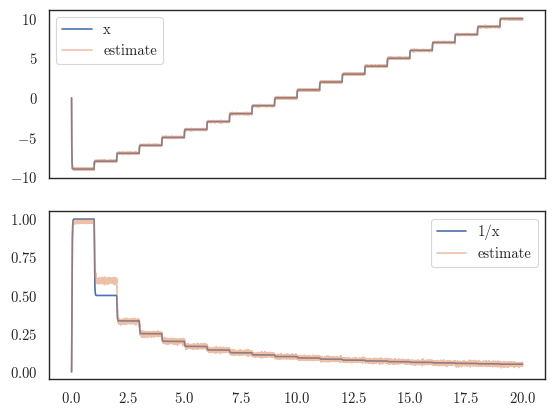

In [25]:
func_inverse = lambda x: 1/(x+10)

with nengo.Network(seed=0) as net:
    inputs = nengo.Node(lambda t: int(t+1)-10)
    pre = nengo.Ensemble(1000, 1, radius=12)  # , max_rates=nengo.dists.Uniform(150, 200), neuron_type=nengo.LIF(tau_ref=0.005))
    post = nengo.Ensemble(1000, 1, radius=0.9)  # , max_rates=nengo.dists.Uniform(200, 300), neuron_type=nengo.LIF(tau_ref=0.002))
    perfect = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
    nengo.Connection(inputs, pre, synapse=None)
    nengo.Connection(pre, post, synapse=0.02, function=func_inverse)
    nengo.Connection(inputs, perfect, synapse=0.01, function=func_inverse)
    p_inputs = nengo.Probe(inputs, synapse=0.01)
    p_pre = nengo.Probe(pre, synapse=0.01)
    p_post = nengo.Probe(post, synapse=0.01)
    p_correct = nengo.Probe(perfect, synapse=0.01)

with nengo.Simulator(net) as sim:
    sim.run(20)

fig, axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(sim.trange(), sim.data[p_inputs], label='x')
axes[0].plot(sim.trange(), sim.data[p_pre], label='estimate', alpha=0.5)
axes[1].plot(sim.trange(), sim.data[p_correct], label='1/x')
axes[1].plot(sim.trange(), sim.data[p_post], label='estimate', alpha=0.5)
axes[0].legend()
axes[1].legend()
plt.show()
fig.savefig("plots/1_over_x.jpg")

### Noise analysis

In [12]:
def mean_history(obs):
    output = []
    for o in range(len(obs)):
        output.append(np.mean(obs[:o+1]))
    return np.array(output)

In [11]:
def weighted_error(obs, noise='none', sigma=0, seed=0):
    output = []
    value = 0
    rng = np.random.RandomState(seed=seed)
    for o in range(len(obs)):
        weight = 1/(o+1)
        if noise=='percent':
            random = rng.normal(0, sigma*weight)
            weight += random
        elif noise=='constant':
            random = rng.normal(0, sigma)
            weight += random
        error = obs[o] - value
        value += weight * error
        output.append(value)
    return np.array(output)

In [30]:
human = pd.read_pickle("data/human.pkl")
sigmas = np.arange(0, 0.1, 0.01)

dfs = []
dfs2 = []
columns = ['sid', 'trial', 'noise', 'sigma', 'final error']
columns2 = ['sid', 'trial', 'noise', 'sigma', 'obs', 'cumulative error']
for noise in ['percent', 'constant']:
    for sigma in sigmas:
        print(noise, sigma)
        for sid in human['sid'].unique():
            for trial in human.query("sid==@sid")['trial'].unique():
                obs = human.query("sid==@sid & trial==@trial")['color'].to_numpy()
                perfect = mean_history(obs)
                prediction = weighted_error(obs, noise, sigma)
                prediction = np.clip(prediction, -1, 1)
                delta = np.cumsum(np.abs(perfect - prediction))
                dfs.append(pd.DataFrame([[sid, trial, noise, sigma, delta[-1]]], columns=columns))
                for o in range(len(obs)):
                    dfs2.append(pd.DataFrame([[sid, trial, noise, sigma, o, delta[o]]], columns=columns2))

final_errors = pd.concat(dfs, ignore_index=True)
cumulative_errors = pd.concat(dfs2, ignore_index=True)

percent 0.0
percent 0.01
percent 0.02
percent 0.03
percent 0.04
percent 0.05
percent 0.06
percent 0.07
percent 0.08
percent 0.09
constant 0.0
constant 0.01
constant 0.02
constant 0.03
constant 0.04
constant 0.05
constant 0.06
constant 0.07
constant 0.08
constant 0.09


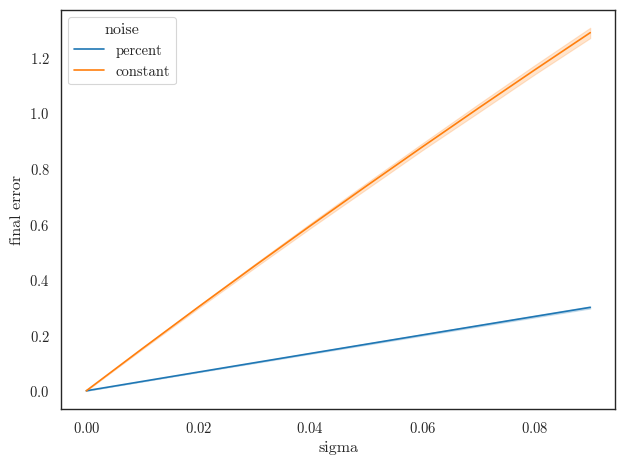

In [31]:
fig, ax = plt.subplots()
sns.lineplot(data=final_errors, x='sigma', y='final error', hue='noise', ax=ax, palette=palette[:2])
plt.tight_layout()
plt.show()

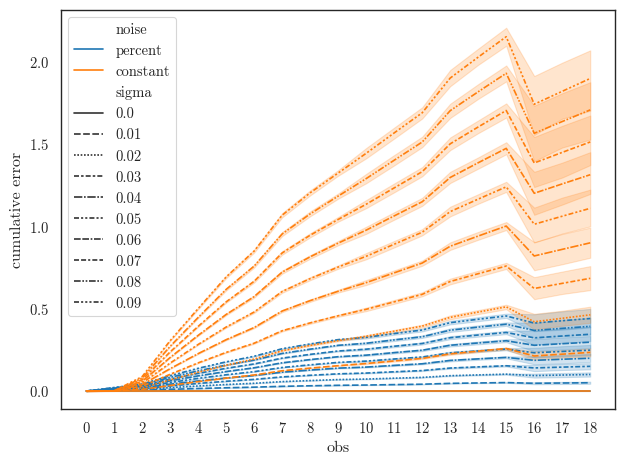

In [36]:
fig, ax = plt.subplots()
sns.lineplot(data=cumulative_errors, x='obs', y='cumulative error', hue='noise', style='sigma', ax=ax, palette=palette[:2])
ax.set(xticks=np.arange(0,19,1))
plt.tight_layout()
plt.show()

### Comparison to human data

In [37]:
human = pd.read_pickle("data/human.pkl")
noise = pd.read_pickle("data/DGn_jan16b_noise.pkl")

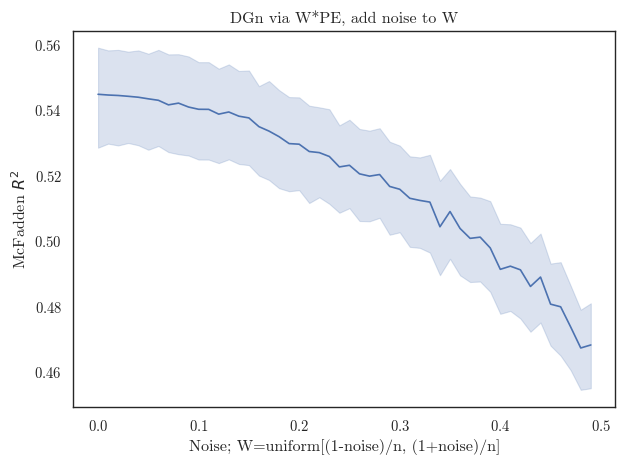

In [46]:
fig, ax = plt.subplots()
sns.lineplot(data=noise, x='sigma', y='McFadden R2', ax=ax)
ax.set(xlabel="Noise; W=uniform[(1-noise)/n, (1+noise)/n]", ylabel=r"McFadden $R^2$", title="DGn via W*PE, add noise to W")
plt.tight_layout()
plt.show()
fig.savefig("plots/DGn_with_W_noise_performance.jpg", dpi=600)